# Introduction to the xgbsurv package

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import (load_metabric, load_flchain, load_rgbsg, load_support, load_tcga)
from xgbsurv import XGBSurv
from xgbsurv.evaluation import cindex_censored, ibs
from xgbsurv.models.utils import sort_X_y
import os
import numpy as np
import pandas as pd
from scipy.stats import uniform as scuniform
from scipy.stats import randint as scrandint
from scipy.stats import loguniform as scloguniform 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
# import models
from xgbsurv.models.eh_ah_final import ah_likelihood, get_cumulative_hazard_function_ah
from pycox.evaluation import EvalSurv
from xgbsurv.models.utils import sort_X_y_pandas, transform_back, transform
from xgbsurv.preprocessing.dataset_preprocessing import discretizer_df
from sklearn.utils.fixes import loguniform
np.random.seed(42)

In [2]:
param_grid = {
# 'estimator__reg_alpha': scloguniform(1e-10,1),#[1e-10,1], # from hyp augmentation, L1 regularization
# 'estimator__reg_lambda': scloguniform(1e-10,1), #[1e-10,1], #alias l2_regularization, lambda in augmentation
 'estimator__learning_rate': scloguniform(0.1,1.0), #[0.001,1], # assumed alias eta from augmentation,
 'estimator__n_estimators':  scrandint(1,500),#00), # corresponds to num_rounds
#'estimator__gamma': loguniform(0.001,1-0.5),#[0.1,1], # minimum loss reduction required to make a further partition on a leaf node of the tree.
'estimator__colsample_bylevel': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation
'estimator__colsample_bynode': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation, uniform(0.1,1),
'estimator__colsample_bytree': scuniform(0.5, 1-0.5),#[0.5,1], # from hyp augmentation, seems to exceed the bound, uniform(0.5,1)
'estimator__max_depth': scrandint(1,20),#[1,20], # from hyp augmentation
'estimator__max_delta_step': scrandint(0,10),#[0,10], # from hyp augmentation
'estimator__min_child_weight' : scloguniform(0.1,20-0.1),#[0.1,20], # from hyp augmentation
'estimator__subsample': scuniform(0.01,1-0.01),#[0.01,1], # from hyp augmentation
}
n_outer_splits = 5
n_inner_splits = 5
rand_state = 42
n_iter = 10 #50 #0
early_stopping_rounds=10
base_score = 0.0
validation_size = 0.2

# 30 estimators no earlystopping 1 iter, - in loss function

# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.516432	0.136174
# 1	0.546220	0.132683
# 2	0.527749	0.133888
# 3	0.549429	0.131120
# 4	0.527424	0.129955

# 30 estimators no earlystopping 2 iter, - in loss function

# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.516432	0.136174
# 1	0.546220	0.132683
# 2	0.527749	0.133888
# 3	0.549429	0.131120
# 4	0.527424	0.129955

# 30 estimators no earlystopping 1 iter, no - in loss function
# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.516432	0.136174
# 1	0.546220	0.132683
# 2	0.527749	0.133888
# 3	0.549429	0.131120
# 4	0.527424	0.129955

# 30 estimators no earlystopping 2 iter, no - in loss function

# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.516432	0.136174
# 1	0.546220	0.132683
# 2	0.527749	0.133888
# 3	0.549429	0.131120
# 4	0.527424	0.129955

# 30 estimators no earlystopping 2 iter, no - in loss function, with early stopping
# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.521266	0.136157
# 1	0.519630	0.132669
# 2	0.496238	0.133871
# 3	0.511963	0.131105
# 4	0.544301	0.129945


# 100 estimators no earlystopping 2 iter, no - in loss function, with early stopping

# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.572931	0.135763
# 1	0.588789	0.131898
# 2	0.574728	0.132877
# 3	0.585196	0.130384
# 4	0.623896	0.129095

# 200 estimators no earlystopping 2 iter, no - in loss function, with early stopping
# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.499066	0.136175
# 1	0.538812	0.132628
# 2	0.529298	0.133803
# 3	0.582504	0.131091
# 4	0.539499	0.129924

# 500 estimators no earlystopping 2 iter, no - in loss function, with early stopping
# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.499066	0.136175
# 1	0.546190	0.132684
# 2	0.574587	0.133869
# 3	0.538273	0.131049
# 4	0.574704	0.129916

# 1000 estimators no earlystopping 2 iter, no - in loss function, with early stopping
# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.499066	0.136175
# 1	0.546190	0.132684
# 2	0.574587	0.133869
# 3	0.538273	0.131049
# 4	0.574704	0.129916


# 100 estimators no earlystopping 2 iter, no - in loss function, with early stopping, greater is better = True

# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.524172	0.136171
# 1	0.550253	0.132680
# 2	0.516797	0.133884
# 3	0.547712	0.131118
# 4	0.565260	0.129951

#only n estimators up to 100
# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.577671	0.131434
# 1	0.590739	0.128732
# 2	0.570734	0.128432
# 3	0.582214	0.126430
# 4	0.603189	0.125220


# learning rate 0.1
# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.507333	0.136161
# 1	0.503731	0.132679
# 2	0.477599	0.133884
# 3	0.514878	0.131111
# 4	0.490775	0.129949

# learning rate 0.6

# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.562555	0.135029
# 1	0.559221	0.131911
# 2	0.546820	0.132987
# 3	0.586294	0.130238
# 4	0.594456	0.129355

# learning rate 1.2

# 	cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.571272	0.133343
# 1	0.554321	0.130437
# 2	0.566414	0.131497
# 3	0.584498	0.128642
# 4	0.582981	0.127896

# same with 10-100 estimators
#     cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.640811	0.127436
# 1	0.573330	0.128683
# 2	0.610161	0.127276
# 3	0.604004	0.125666
# 4	0.617280	0.124759


# learning rate 3 and up 10 estimators
# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.654684	0.127838
# 1	0.700567	0.126939
# 2	0.618726	0.126297
# 3	0.694826	0.124449
# 4	0.635148	0.122924

# learning 4.5

# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.717075	0.124031
# 1	0.736950	0.124716
# 2	0.678451	0.123787
# 3	0.689789	0.121705
# 4	0.718303	0.119297

# no reg params

# cindex_test_FLCHAIN	ibs_test_FLCHAIN
# 0	0.530256	0.136220
# 1	0.712447	0.125573
# 2	0.708846	0.120694
# 3	0.705460	0.125078
# 4	0.756776	0.116464
#maybe lower is better reverse in skorch, but it does not seem to make a difference, prob need n_iter=2

In [3]:
#scoring_function = make_scorer(aft_likelihood, greater_is_better=False) #changed here
def custom_scoring_function(y_true, y_pred):

        if not isinstance(y_true, np.ndarray):
            y_true = y_true.values
        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.values
        # change order of this later
        score = ah_likelihood(y_true, y_pred)
        return score

scoring_function = make_scorer(custom_scoring_function, greater_is_better=False)

In [4]:
class CustomSplit(StratifiedKFold):
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y, groups=None):
        try:
            if y.shape[1]>1:
                y = y[:,0]
        except:
            pass
        bins = np.sign(y)
        return super().split(X, bins, groups=groups)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

outer_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)
inner_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)

In [5]:


ct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=['float32'])),
        #(OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['category', 'object'])),
        remainder='passthrough')

estimator = XGBSurv(
    objective='ah_objective',
    eval_metric='ah_loss',
    #learning_rate=0.8,
    random_state=rand_state, 
    disable_default_eval_metric=True,
    early_stopping_rounds=early_stopping_rounds, 
    base_score=base_score,
    verbosity=0)
pipe = Pipeline([('scaler',ct),
                ('estimator', estimator)])
    
rs = RandomizedSearchCV(pipe, param_grid, scoring = scoring_function, n_jobs=-1, 
                             cv=inner_custom_cv, n_iter=n_iter, refit=True, 
                             random_state=rand_state, verbose=0,
                             error_score = 'raise')
data = load_flchain(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=True)
filename = data.filename
dataset_name = filename.split('_')[0]
outer_scores = {'cindex_test_'+dataset_name:[],'ibs_test_'+dataset_name:[]}
X  = data.data #.astype(np.float32)
y = data.target #.values #.to_numpy()

for i, (train_index, test_index) in enumerate(outer_custom_cv.split(X, y)):
        # Split data into training and testing sets for outer fold

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, y_train = sort_X_y_pandas(X_train, y_train)
        X_test, y_test = sort_X_y_pandas(X_test, y_test)
        rs.fit(X_train, y_train, estimator__eval_test_size=validation_size,estimator__verbose=0) #

        best_preds_train = rs.best_estimator_.predict(X_train)
        best_preds_test = rs.best_estimator_.predict(X_test)
        cum_hazard_test = get_cumulative_hazard_function_ah(
                X_train.values, X_test.values, y_train.values, y_test.values,
                best_preds_train, best_preds_test
                )
        df_survival_test = np.exp(-cum_hazard_test)
        durations_test, events_test = transform_back(y_test.values)
        time_grid_test = np.linspace(durations_test.min(), durations_test.max(), 100)
        ev = EvalSurv(df_survival_test, durations_test, events_test, censor_surv='km')
        print('Concordance Index Test',ev.concordance_td('antolini'))
        print('Integrated Brier Score Test',ev.integrated_brier_score(time_grid_test))
        cindex_score_test = ev.concordance_td('antolini')
        ibs_score_test = ev.integrated_brier_score(time_grid_test)
        outer_scores['cindex_test_'+dataset_name] += [cindex_score_test]
        outer_scores['ibs_test_'+dataset_name] += [ibs_score_test]

0.999999
integration times 33227
Concordance Index Test 0.7597480031499606
Integrated Brier Score Test 0.11063425417786472
0.999999
integration times 31476
Concordance Index Test 0.773731165925527
Integrated Brier Score Test 0.11298651793110448


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(outer_scores)

,cindex_test_FLCHAIN,ibs_test_FLCHAIN
0,0.740513,0.133259
1,0.776061,0.122510
2,0.765527,0.122962
3,0.755941,0.122768
4,0.773067,0.119942


In [ ]:
best_preds_train = rs.best_estimator_.predict(X_train)
best_preds_test = rs.best_estimator_.predict(X_test)
print('best_preds_train',best_preds_train)
print('best_preds_test',best_preds_test)
print(best_preds_train.shape)
print(best_preds_test.shape)

best_preds_train [0.02575131 0.02777177 0.04459855 ... 0.00870776 0.04181195 0.01966785]
best_preds_test [ 0.01950745 -0.00152888 -0.04768422 ...  0.00330476  0.01514807
  0.01774651]
(6297,)
(1574,)


In [ ]:
cum_hazard_test = get_cumulative_hazard_function_ah(
        X_train.values, X_test.values, y_train.values, y_test.values,
        best_preds_train.reshape(-1), best_preds_test.reshape(-1)
        )

df_survival_test = np.exp(-cum_hazard_test)
durations_test, events_test = transform_back(y_test.values)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 200)
ev = EvalSurv(df_survival_test, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
#flchain without onehot encoding: 0.7877551707497727, n_iter=2: ,0.767814724619465 with loss function sign changed
#flchain with onehot encoding:


0.999999
integration times 5457
Concordance Index 0.5602365695175463


In [ ]:
cindex_censored(y_test, preds_test)

NameError: name 'preds_test' is not defined

## Predict Survival Function

In [ ]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
318.200012,0.241719,0.226924,0.203765,0.191910,0.236460,0.226924,0.206582,0.223351,0.236288,0.206318,...,0.236460,0.219993,0.217993,0.223718,0.235301,0.228127,0.235301,0.217317,0.234916,0.214751
335.600006,0.221201,0.206847,0.184586,0.173280,0.216089,0.206847,0.187317,0.203429,0.215931,0.187043,...,0.216089,0.200176,0.198278,0.203765,0.214986,0.208062,0.214986,0.197625,0.214594,0.195140
351.000000,0.204438,0.190542,0.169125,0.158284,0.199481,0.190542,0.171726,0.187249,0.199334,0.171473,...,0.199481,0.184112,0.182262,0.187593,0.198387,0.191699,0.198387,0.181627,0.198060,0.179273


### Visualize Predictions

Text(0.5, 1.0, 'Survival Curve Test Set')

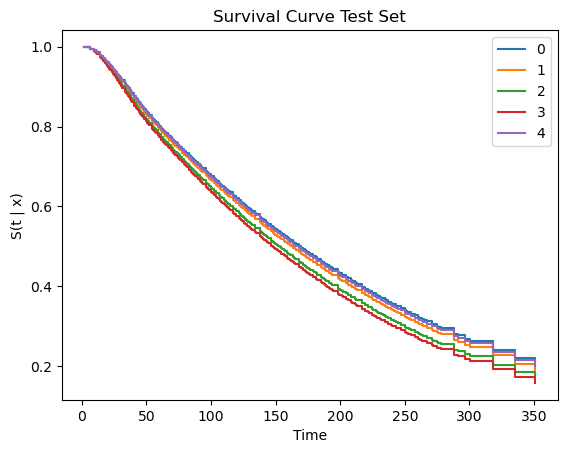

In [ ]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

## Evaluate

In [ ]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.6070646458397773


In [ ]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.18551198595050641
